# Traffic Sign Recognition using Few-Shot Learning (CNN MODEL)

## LOADING DATA

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [7]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [01:59<00:00, 5.39MB/s] 

Extracting files...


Path to dataset files: C:\Users\VINOTH RAJENDRAN\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [8]:
import shutil

colab_path = "/content"
shutil.copytree(path, colab_path, dirs_exist_ok=True)

print("Datasets copied to Colab workspace.")


Datasets copied to Colab workspace.


## EXPLORING DATASET

In [9]:
import os

dataset_path = "/content"

print("Dataset contents:", os.listdir(dataset_path))

print("Train Folder:", os.listdir(os.path.join(dataset_path, "Train"))[:5])
print("Test Folder:", os.listdir(os.path.join(dataset_path, "Test"))[:5])

Dataset contents: ['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']
Train Folder: ['0', '1', '10', '11', '12']
Test Folder: ['00000.png', '00001.png', '00002.png', '00003.png', '00004.png']


In [5]:
import os

train_path = "/content/Train"

classes = sorted(os.listdir(train_path))
num_classes = len(classes)

class_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in classes}

print(f"Total Number of Classes: {num_classes}")
print("Images per class:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} images")


Total Number of Classes: 43
Images per class:
Class 0: 210 images
Class 1: 2220 images
Class 10: 2010 images
Class 11: 1320 images
Class 12: 2100 images
Class 13: 2160 images
Class 14: 780 images
Class 15: 630 images
Class 16: 420 images
Class 17: 1110 images
Class 18: 1200 images
Class 19: 210 images
Class 2: 2250 images
Class 20: 360 images
Class 21: 330 images
Class 22: 390 images
Class 23: 510 images
Class 24: 270 images
Class 25: 1500 images
Class 26: 600 images
Class 27: 240 images
Class 28: 540 images
Class 29: 270 images
Class 3: 1410 images
Class 30: 450 images
Class 31: 780 images
Class 32: 240 images
Class 33: 689 images
Class 34: 420 images
Class 35: 1200 images
Class 36: 390 images
Class 37: 210 images
Class 38: 2070 images
Class 39: 300 images
Class 4: 1980 images
Class 40: 360 images
Class 41: 240 images
Class 42: 240 images
Class 5: 1860 images
Class 6: 420 images
Class 7: 1440 images
Class 8: 1410 images
Class 9: 1470 images


In [6]:
test_path = "/content/Test"

num_test_images = len(os.listdir(test_path))

print(f"Total Number of Test Images: {num_test_images}")


Total Number of Test Images: 12631


In [7]:
import pandas as pd

test_csv_path = "/content/Test.csv"

df = pd.read_csv(test_csv_path)

test_class_counts = df['ClassId'].value_counts().sort_index()

print(f"Total Number of Test Images: {len(df)}")
print("Test Images per Class:")
print(test_class_counts)


Total Number of Test Images: 12630
Test Images per Class:
ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: count, dtype: int64


## Custom Few-Shot Learning Dataset Loader

In [8]:
import torch
import random
import os
from torchvision import transforms
from PIL import Image

class TrafficSignFewShotDataset(torch.utils.data.Dataset):
    def __init__(self, root, num_classes=5, num_support=1, num_query=5, image_size=84):
        self.root = root
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.data_by_class = {}
        for class_name in sorted(os.listdir(root)):
            class_path = os.path.join(root, class_name)

            if os.path.isdir(class_path):
                image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.png') or img.endswith('.jpg')]
                if len(image_files) >= self.num_support + self.num_query:
                    self.data_by_class[class_name] = image_files
        self.class_list = sorted(list(self.data_by_class.keys()))

    def sample_episode(self):
        if len(self.class_list) < self.num_classes:
            raise ValueError("Not enough classes to sample required N-way task.")

        selected_classes = random.sample(self.class_list, self.num_classes)
        support_set, query_set = [], []
        real_labels = {}

        for temp_label, cls in enumerate(selected_classes):
            real_labels[temp_label] = cls

            if len(self.data_by_class[cls]) < self.num_support + self.num_query:
                continue

            images = random.sample(self.data_by_class[cls], self.num_support + self.num_query)
            support_set.extend([(img, temp_label) for img in images[:self.num_support]])
            query_set.extend([(img, temp_label) for img in images[self.num_support:]])

        return support_set, query_set, real_labels

    def __getitem__(self, index):
        support_set, query_set, real_labels = self.sample_episode()

        def load_image(data):
            images, labels = [], []
            for img_path, label in data:
                img = Image.open(img_path).convert("RGB")
                img = self.transform(img)
                images.append(img)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        support_images, support_labels = load_image(support_set)
        query_images, query_labels = load_image(query_set)

        return support_images, support_labels, query_images, query_labels, real_labels  # ✅ Return real label mapping

    def __len__(self):
        return 1000


## CNN-Based Feature Extractor for Prototypical Networks

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ProtoNet(nn.Module):
    def __init__(self, feature_dim=64):
        super(ProtoNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, feature_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.encoder(x).view(x.shape[0], -1)

In [11]:
def euclidean_distance(a, b):
    return torch.sum((a.unsqueeze(1) - b.unsqueeze(0)) ** 2, dim=2)


## TRAINING MODEL

In [11]:
from tqdm import tqdm

def train_protonet(model, dataloader, optimizer, num_epochs=50, device="cuda"):
    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_acc = 0.0

        for support_imgs, support_labels, query_imgs, query_labels, _  in tqdm(dataloader):
            support_imgs, query_imgs = support_imgs.squeeze(0).to(device), query_imgs.squeeze(0).to(device)
            support_labels, query_labels = support_labels.squeeze(0).to(device), query_labels.squeeze(0).to(device)

            support_embeddings = model(support_imgs)
            query_embeddings = model(query_imgs)

            unique_labels = torch.unique(support_labels)
            prototypes = torch.stack([support_embeddings[support_labels == lbl].mean(0) for lbl in unique_labels])

            dists = euclidean_distance(query_embeddings, prototypes)
            log_p_y = F.log_softmax(-dists, dim=1)

            loss = F.nll_loss(log_p_y, query_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predictions = torch.max(log_p_y, 1)
            acc = (predictions == query_labels).float().mean()

            total_loss += loss.item()
            total_acc += acc.item()

        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {total_loss/len(dataloader):.4f}, Accuracy = {total_acc/len(dataloader):.4f}")


In [12]:
num_classes = 30
num_support = 10
num_query = 10
num_epochs = 5
batch_size = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

train_path = "/content/Train"

train_dataset = TrafficSignFewShotDataset(root=train_path, num_classes=num_classes, num_support=num_support, num_query=num_query)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = ProtoNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_protonet(model, train_loader, optimizer, num_epochs=num_epochs, device=device)

model_path = "/content/protonet_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")



100%|██████████| 1000/1000 [13:10<00:00,  1.26it/s]


Epoch 1/5: Loss = 2.9841, Accuracy = 0.8318


100%|██████████| 1000/1000 [12:52<00:00,  1.29it/s]


Epoch 2/5: Loss = 0.1334, Accuracy = 0.9583


100%|██████████| 1000/1000 [13:18<00:00,  1.25it/s]


Epoch 3/5: Loss = 0.0620, Accuracy = 0.9805


100%|██████████| 1000/1000 [12:55<00:00,  1.29it/s]


Epoch 4/5: Loss = 0.0399, Accuracy = 0.9874


100%|██████████| 1000/1000 [12:48<00:00,  1.30it/s]

Epoch 5/5: Loss = 0.0251, Accuracy = 0.9918
Model saved at /content/protonet_model.pth


## TRAINING DATA ACCURACY

In [13]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def train_protonet_evaluation(model, train_loader, device="cuda"):
    model.eval()
    train_total_correct = 0
    train_total_samples = 0

    all_train_true_labels = []
    all_train_pred_labels = []

    with torch.no_grad():
        for batch in train_loader:
            support_images, support_labels, query_images, query_labels, real_labels = batch
            support_images, support_labels = support_images.squeeze(0).to(device), support_labels.squeeze(0).to(device)
            query_images, query_labels = query_images.squeeze(0).to(device), query_labels.squeeze(0).to(device)


            support_embeddings = model(support_images)
            unique_labels = torch.unique(support_labels)
            prototypes = torch.stack([support_embeddings[support_labels == lbl].mean(0) for lbl in unique_labels])

            query_embeddings = model(query_images)
            dists = euclidean_distance(query_embeddings, prototypes)
            predicted_labels = torch.argmin(dists, dim=1)


            real_pred_labels = [real_labels[pred.item()] for pred in predicted_labels]
            real_train_labels = [real_labels[true.item()] for true in query_labels]

            correct = sum(p == t for p, t in zip(real_pred_labels, real_train_labels))
            train_total_correct += correct
            train_total_samples += len(real_train_labels)

            all_train_pred_labels.extend(real_pred_labels)
            all_train_true_labels.extend(real_train_labels)

    precision = precision_score(all_train_true_labels, all_train_pred_labels, average='macro')
    recall = recall_score(all_train_true_labels, all_train_pred_labels, average='macro')
    f1 = f1_score(all_train_true_labels, all_train_pred_labels, average='macro')

    train_accuracy = (train_total_correct / train_total_samples) * 100

    print(f"Final Training Accuracy: {train_accuracy:.2f}%")
    print(f"Train Precision: {precision:.4f}, Train Recall: {recall:.4f}, Train F1-score: {f1:.4f}")

    return train_accuracy, precision, recall, f1

train_accuracy, precision, recall, f1 = train_protonet_evaluation(model, train_loader, device="cuda")


Final Training Accuracy: 99.30%
Train Precision: 0.9930, Train Recall: 0.9930, Train F1-score: 0.9930


## TESTING DATA ACCURACY

In [14]:
import torch
import os
import pandas as pd
import random
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from tqdm import tqdm
import gc
from sklearn.metrics import precision_score, recall_score, f1_score

def load_test_labels(csv_path):

    df = pd.read_csv(csv_path)
    label_map = {row["Path"].split("/")[-1]: row["ClassId"] for _, row in df.iterrows()}
    return label_map

import torch
import os
import random
from PIL import Image
from torchvision import transforms

def create_support_set(train_path, batch_size=500, image_size=84, device="cuda", seed=42):

    random.seed(seed)
    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    support_embeddings = []
    support_labels = []

    class_folders = sorted(os.listdir(train_path))
    total_images = 0

    for class_folder in class_folders:
        class_path = os.path.join(train_path, class_folder)

        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        batch = []
        batch_labels = []

        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path).convert("RGB")
            image = transform(image).to(device)
            batch.append(image)
            batch_labels.append(int(class_folder))

            if len(batch) == batch_size:
                batch_tensor = torch.stack(batch).to(device)
                batch_labels_tensor = torch.tensor(batch_labels, device=device)

                with torch.no_grad():
                    batch_embeddings = model(batch_tensor).cpu()

                support_embeddings.append(batch_embeddings)
                support_labels.append(batch_labels_tensor.cpu())
                del batch_tensor, batch_labels_tensor, batch_embeddings
                torch.cuda.empty_cache()
                gc.collect()

                batch = []
                batch_labels = []


        if batch:
            batch_tensor = torch.stack(batch).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                batch_embeddings = model(batch_tensor).cpu()

            support_embeddings.append(batch_embeddings)
            support_labels.append(batch_labels_tensor.cpu())

            del batch_tensor, batch_labels_tensor, batch_embeddings
            torch.cuda.empty_cache()
            gc.collect()

        total_images += len(image_files)

    support_embeddings = torch.cat(support_embeddings, dim=0)
    support_labels = torch.cat(support_labels, dim=0)

    print(f"Support set created with {total_images} images from {len(torch.unique(support_labels))} classes (Processed in batches).")
    return support_embeddings, support_labels

def evaluate_protonet(model, train_path, test_path, test_csv, device="cuda", test_batch_size=100):
    model.eval()
    model.to(device)
    all_test_true_labels = []
    all_test_pred_labels = []

    support_embeddings, support_labels = create_support_set(train_path, batch_size=500, device=device)

    unique_labels = torch.unique(support_labels)
    class_prototypes = {}

    for lbl in unique_labels:
        class_prototypes[lbl.item()] = support_embeddings[support_labels == lbl].mean(0).cpu()

    prototype_tensors = torch.stack([class_prototypes[lbl] for lbl in sorted(class_prototypes.keys())]).to(device)

    test_labels = load_test_labels(test_csv)

    transform = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    correct = 0
    total = 0
    all_test_pred_labels = []
    all_test_true_labels = []

    test_images = sorted(os.listdir(test_path))

    for i in tqdm(range(0, len(test_images), test_batch_size), desc="Processing Test Images"):
        batch_files = test_images[i : i + test_batch_size]
        batch_images = []
        batch_labels = []

        for image_name in batch_files:
            image_path = os.path.join(test_path, image_name)

            if not (image_name.endswith(".png") or image_name.endswith(".jpg") or image_name.endswith(".jpeg")):
                continue

            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image)
                batch_images.append(image)
                batch_labels.append(test_labels.get(image_name, -1))
            except Exception as e:
                print(f"Skipping invalid image {image_name}: {e}")
                continue

        if not batch_images:
            continue

        batch_tensor = torch.stack(batch_images).to(device)
        test_embeddings = model(batch_tensor)
        distances = torch.cdist(test_embeddings, prototype_tensors, p=2)
        predicted_classes = torch.argmin(distances, dim=1).cpu().numpy()
        for pred, actual in zip(predicted_classes, batch_labels):
            if actual != -1:
                all_test_pred_labels.append(pred)
                all_test_true_labels.append(actual)
                if pred == actual:
                    correct += 1
                total += 1

        del batch_tensor, test_embeddings, distances
        torch.cuda.empty_cache()
        gc.collect()

    all_test_pred_labels.extend(predicted_classes)
    all_test_true_labels.extend(batch_labels)

    test_accuracy = (correct / total) * 100 if total > 0 else 0

    precision = precision_score(all_test_true_labels, all_test_pred_labels, average='macro', zero_division=0)
    recall = recall_score(all_test_true_labels, all_test_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(all_test_true_labels, all_test_pred_labels, average='macro', zero_division=0)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-score: {f1:.4f}")

    del support_embeddings, support_labels, prototype_tensors, model
    torch.cuda.empty_cache()
    gc.collect()
    return test_accuracy, precision, recall, f1,all_test_true_labels, all_test_pred_labels



In [15]:

train_path = "/content/Train"
test_path = "/content/Test"
test_csv = "/content/Test.csv"

test_accuracy, precision, recall, f1, all_test_true_labels, all_test_pred_labels = evaluate_protonet(model, train_path, test_path, test_csv, device="cuda")


Support set created with 39209 images from 43 classes (Processed in batches).


Processing Test Images: 100%|██████████| 127/127 [00:35<00:00,  3.55it/s]


Test Accuracy: 97.42%
Test Precision: 0.9656, Test Recall: 0.9630, Test F1-score: 0.9633


## CONFUSION MATRIX

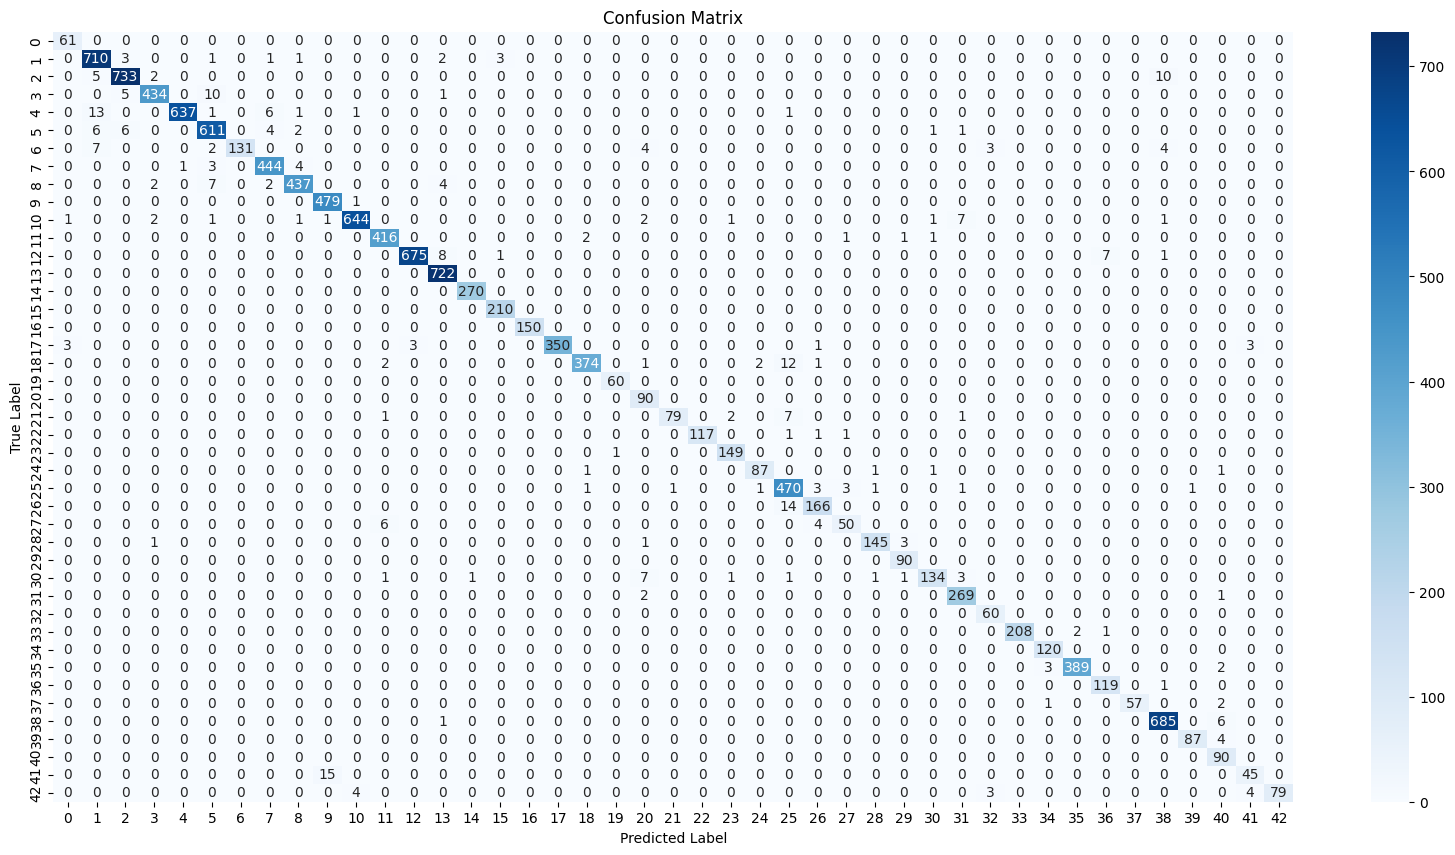

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(20, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(all_test_true_labels, all_test_pred_labels, class_names=[str(i) for i in range(43)])


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = ProtoNet().to(device)

# Load the saved weights
model.load_state_dict(torch.load(r"C:\Users\VINOTH RAJENDRAN\Downloads\protonet_model_CNN.pth", map_location=device))

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [17]:
import torch
import os
import pandas as pd
import random
from PIL import Image
from torchvision import transforms
import gc
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

def load_test_labels(csv_path):
    df = pd.read_csv(csv_path)
    label_map = {row["Path"].split("/")[-1]: row["ClassId"] for _, row in df.iterrows()}
    return label_map

def create_support_set(train_path, batch_size=500, image_size=84, device="cuda", seed=42):
    random.seed(seed)
    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    support_embeddings = []
    support_labels = []

    class_folders = sorted(os.listdir(train_path))
    total_images = 0

    for class_folder in class_folders:
        class_path = os.path.join(train_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        batch = []
        batch_labels = []

        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path).convert("RGB")
            image = transform(image).to(device)
            batch.append(image)
            batch_labels.append(int(class_folder))

            if len(batch) == batch_size:
                batch_tensor = torch.stack(batch).to(device)
                batch_labels_tensor = torch.tensor(batch_labels, device=device)

                with torch.no_grad():
                    batch_embeddings = model(batch_tensor).cpu()

                support_embeddings.append(batch_embeddings)
                support_labels.append(batch_labels_tensor.cpu())

                del batch_tensor, batch_labels_tensor, batch_embeddings
                torch.cuda.empty_cache()
                gc.collect()
                batch = []
                batch_labels = []

        if batch:
            batch_tensor = torch.stack(batch).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                batch_embeddings = model(batch_tensor).cpu()

            support_embeddings.append(batch_embeddings)
            support_labels.append(batch_labels_tensor.cpu())

            del batch_tensor, batch_labels_tensor, batch_embeddings
            torch.cuda.empty_cache()
            gc.collect()

        total_images += len(image_files)

    support_embeddings = torch.cat(support_embeddings, dim=0)
    support_labels = torch.cat(support_labels, dim=0)

    print(f"Support set created with {total_images} images from {len(torch.unique(support_labels))} classes.")
    return support_embeddings, support_labels


def evaluate_protonet(model, train_path, test_path, test_csv, device=None, test_batch_size=100):
    device = torch.device("cpu")  # Force CPU


    model.eval()
    model.to(device)

    all_test_true_labels = []
    all_test_pred_labels = []

    support_embeddings, support_labels = create_support_set(train_path, batch_size=500, device=device)
    unique_labels = torch.unique(support_labels)
    class_prototypes = {lbl.item(): support_embeddings[support_labels == lbl].mean(0).cpu() for lbl in unique_labels}
    prototype_tensors = torch.stack([class_prototypes[lbl] for lbl in sorted(class_prototypes.keys())]).to(device)

    test_labels = load_test_labels(test_csv)

    transform = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    correct = 0
    total = 0
    test_images = sorted(os.listdir(test_path))

    for i in tqdm(range(0, len(test_images), test_batch_size), desc="Processing Test Images"):
        batch_files = test_images[i: i + test_batch_size]
        batch_images = []
        batch_labels = []

        for image_name in batch_files:
            image_path = os.path.join(test_path, image_name)
            if not (image_name.endswith(".png") or image_name.endswith(".jpg") or image_name.endswith(".jpeg")):
                continue

            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image)
                batch_images.append(image)
                batch_labels.append(test_labels.get(image_name, -1))
            except Exception as e:
                print(f"Skipping invalid image {image_name}: {e}")
                continue

        if not batch_images:
            continue

        batch_tensor = torch.stack(batch_images).to(device)
        test_embeddings = model(batch_tensor)
        distances = torch.cdist(test_embeddings, prototype_tensors, p=2)
        predicted_classes = torch.argmin(distances, dim=1).cpu().numpy()

        for pred, actual in zip(predicted_classes, batch_labels):
            if actual != -1:
                all_test_pred_labels.append(pred)
                all_test_true_labels.append(actual)
                if pred == actual:
                    correct += 1
                total += 1

        del batch_tensor, test_embeddings, distances
        torch.cuda.empty_cache()
        gc.collect()

    test_accuracy = (correct / total) * 100 if total > 0 else 0
    precision = precision_score(all_test_true_labels, all_test_pred_labels, average='macro', zero_division=0)
    recall = recall_score(all_test_true_labels, all_test_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(all_test_true_labels, all_test_pred_labels, average='macro', zero_division=0)

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    del support_embeddings, support_labels, prototype_tensors, model
    torch.cuda.empty_cache()
    gc.collect()

    return test_accuracy, precision, recall, f1, all_test_true_labels, all_test_pred_labels

def classify_new_image(model, train_path, image_path, device="cuda"):
    model.eval()
    model.to(device)

    support_embeddings, support_labels = create_support_set(train_path, batch_size=500, device=device)
    unique_labels = torch.unique(support_labels)
    class_prototypes = {lbl.item(): support_embeddings[support_labels == lbl].mean(0).cpu() for lbl in unique_labels}
    prototype_tensors = torch.stack([class_prototypes[lbl] for lbl in sorted(class_prototypes.keys())]).to(device)

    transform = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    with torch.no_grad():
        image_embedding = model(image)

    distances = torch.cdist(image_embedding, prototype_tensors, p=2)
    predicted_class = torch.argmin(distances, dim=1).item()

    print(f"Predicted Class: {predicted_class}")

    del support_embeddings, support_labels, prototype_tensors, image_embedding
    torch.cuda.empty_cache()
    gc.collect()

    return predicted_class

# Example usage:
# model = load_your_model()  # Load your trained model
train_path = "/content/Train"
test_path = "/content/Test"
test_csv = "/content/Test.csv"
image_path = "D:/Satvik/IOT/Project/image_1743074312.jpg"

# Evaluate the model
test_accuracy, precision, recall, f1, all_test_true_labels, all_test_pred_labels = evaluate_protonet(model, train_path, test_path, test_csv, device="cuda")

# Classify a new image
predicted_class = classify_new_image(model, train_path, image_path)
print(f"The new image belongs to class: {predicted_class}")


Support set created with 39209 images from 43 classes.


Processing Test Images: 100%|██████████| 127/127 [01:45<00:00,  1.20it/s]


Test Accuracy: 97.42%
Precision: 0.9656, Recall: 0.9631, F1-score: 0.9634


AssertionError: Torch not compiled with CUDA enabled

## LOAD INDIAN TRAFFIC DATASET

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sarangdilipjodh/indian-traffic-signs-prediction85-classes")

print("Path to dataset files:", path)

100%|██████████| 1.13G/1.13G [00:18<00:00, 64.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sarangdilipjodh/indian-traffic-signs-prediction85-classes/versions/1


In [18]:
import shutil

colab_path = "/content"
shutil.copytree(path, colab_path, dirs_exist_ok=True)

print("Datasets copied to Colab workspace.")


Datasets copied to Colab workspace.


## MOVE CATTLE IMAGES TO CONTENT DIRECTORY

In [19]:
import shutil
import os

train_cattle_src = "/content/traffic_sign_classification_dataset/train/CATTLE"
test_cattle_src = "/content/traffic_sign_classification_dataset/test/CATTLE"

train_cattle_dest = "/content/CATTLE_train"
test_cattle_dest = "/content/CATTLE_test"

os.makedirs(train_cattle_dest, exist_ok=True)
os.makedirs(test_cattle_dest, exist_ok=True)

shutil.move(train_cattle_src, train_cattle_dest)

shutil.move(test_cattle_src, test_cattle_dest)

print(f"✅ Moved CATTLE train images to {train_cattle_dest}")
print(f"✅ Moved CATTLE test images to {test_cattle_dest}")


✅ Moved CATTLE train images to /content/CATTLE_train
✅ Moved CATTLE test images to /content/CATTLE_test


## TEST MODEL WITH NEW CLASS

In [20]:
import torch
import os
import random
import gc
from PIL import Image
from torchvision import transforms

def create_support_set(train_path, cattle_path, batch_size=500, image_size=84, device="cuda", seed=42):
    random.seed(seed)
    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    support_embeddings = []
    support_labels = []
    class_folders = sorted(os.listdir(train_path))
    total_images = 0

    for class_folder in class_folders:
        class_path = os.path.join(train_path, class_folder)

        if not os.path.isdir(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        batch = []
        batch_labels = []

        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path).convert("RGB")
            image = transform(image).to(device)
            batch.append(image)
            batch_labels.append(int(class_folder))

            if len(batch) == batch_size:
                batch_tensor = torch.stack(batch).to(device)
                batch_labels_tensor = torch.tensor(batch_labels, device=device)

                with torch.no_grad():
                    batch_embeddings = model(batch_tensor).cpu()

                support_embeddings.append(batch_embeddings)
                support_labels.append(batch_labels_tensor.cpu())

                del batch_tensor, batch_labels_tensor, batch_embeddings
                torch.cuda.empty_cache()
                gc.collect()

                batch = []
                batch_labels = []

        if batch:
            batch_tensor = torch.stack(batch).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                batch_embeddings = model(batch_tensor).cpu()

            support_embeddings.append(batch_embeddings)
            support_labels.append(batch_labels_tensor.cpu())

            del batch_tensor, batch_labels_tensor, batch_embeddings
            torch.cuda.empty_cache()
            gc.collect()

        total_images += len(image_files)

    print("🔍 Adding CATTLE images as class 43...")

    cattle_images = [f for f in os.listdir(cattle_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    batch = []
    batch_labels = []
    for img_name in cattle_images:
        img_path = os.path.join(cattle_path, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).to(device)
        batch.append(image)
        batch_labels.append(43)

        if len(batch) == batch_size:
            batch_tensor = torch.stack(batch).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                batch_embeddings = model(batch_tensor).cpu()

            support_embeddings.append(batch_embeddings)
            support_labels.append(batch_labels_tensor.cpu())

            del batch_tensor, batch_labels_tensor, batch_embeddings
            torch.cuda.empty_cache()
            gc.collect()

            batch = []
            batch_labels = []

    if batch:
        batch_tensor = torch.stack(batch).to(device)
        batch_labels_tensor = torch.tensor(batch_labels, device=device)

        with torch.no_grad():
            batch_embeddings = model(batch_tensor).cpu()

        support_embeddings.append(batch_embeddings)
        support_labels.append(batch_labels_tensor.cpu())

        del batch_tensor, batch_labels_tensor, batch_embeddings
        torch.cuda.empty_cache()
        gc.collect()

    total_images += len(cattle_images)

    support_embeddings = torch.cat(support_embeddings, dim=0)
    support_labels = torch.cat(support_labels, dim=0)

    print(f"Support set created with {total_images} images from {len(torch.unique(support_labels))} classes (Processed in batches).")
    return support_embeddings, support_labels


In [21]:
import torch
import os
import gc
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_cattle_protonet(model, train_path, cattle_train_path,cattle_test_path, device="cuda", batch_size=100):
    model.eval()
    model.to(device)
    support_embeddings, support_labels = create_support_set(train_path, cattle_train_path, batch_size=500, device=device)

    unique_labels = torch.unique(support_labels)
    class_prototypes = {lbl.item(): support_embeddings[support_labels == lbl].mean(0).cpu() for lbl in unique_labels}

    prototype_tensors = torch.stack([class_prototypes[lbl] for lbl in sorted(class_prototypes.keys())]).to(device)

    transform = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    correct = 0
    total = 0
    all_test_pred_labels = []
    all_test_true_labels = []

    cattle_images = sorted([f for f in os.listdir(cattle_test_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for i in tqdm(range(0, len(cattle_images), batch_size), desc="Processing CATTLE Images"):
        batch_files = cattle_images[i: i + batch_size]
        batch_images = []
        batch_labels = []

        for image_name in batch_files:
            image_path = os.path.join(cattle_test_path, image_name)

            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image)
                batch_images.append(image)
                batch_labels.append(43)
            except Exception as e:
                print(f"Skipping invalid image {image_name}: {e}")
                continue

        if not batch_images:
            continue

        batch_tensor = torch.stack(batch_images).to(device)
        test_embeddings = model(batch_tensor)

        distances = torch.cdist(test_embeddings, prototype_tensors, p=2)
        predicted_classes = torch.argmin(distances, dim=1).cpu().numpy()

        for pred, actual in zip(predicted_classes, batch_labels):
            all_test_pred_labels.append(pred)
            all_test_true_labels.append(actual)
            if pred == actual:
                correct += 1
            total += 1

        del batch_tensor, test_embeddings, distances
        torch.cuda.empty_cache()
        gc.collect()

    test_accuracy = (correct / total) * 100 if total > 0 else 0
    del support_embeddings, support_labels, prototype_tensors, model
    torch.cuda.empty_cache()
    gc.collect()

    return test_accuracy, all_test_true_labels, all_test_pred_labels


In [22]:
train_path = "/content/Train"
cattle_train_path = "/content/CATTLE_train/CATTLE"
cattle_test_path = "/content/CATTLE_test/CATTLE"

cattle_accuracy, true_labels, pred_labels = evaluate_cattle_protonet(model, train_path, cattle_train_path,cattle_test_path)

print(f"CATTLE Accuracy: {cattle_accuracy:.2f}%")


🔍 Adding CATTLE images as class 43...
Support set created with 39245 images from 44 classes (Processed in batches).


Processing CATTLE Images: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


CATTLE Accuracy: 100.00%
